L’analisi di visibilità è un argomento molto interessante da trattare con Python. In un [mio articolo](https://massimilianomoraca.it/blog/gis/analisi-di-visibilita/) l’ho affrontata usando QGIS, qui oggi vediamo come raggiungere lo stesso obiettivo con Python.

## Prima di iniziare


### Librerie
Per raggiungere l'obiettivo userò le librerie che seguono:


In [1]:
from pathlib import Path
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
from xrspatial import hillshade, viewshed
from xarray.plot import imshow

### Fonti dati
Come [DEM](https://massimilianomoraca.it/blog/gis/3d-open-source/) ho usato un ritaglio del progetto [DEM20 di ISPRA](http://www.sinanet.isprambiente.it/it/sia-ispra/download-mais/dem20/view) su cui ho posizionato con QGIS undici punti; nell'articolo del blog uso l'undicesimo, qui proverò ad usarli tutti.

In [2]:
sample_data = Path.cwd().parent.parent.joinpath('sample_data/viewshed')
dem = sample_data.joinpath('ispra_dtm_20.tif')
points = sample_data.joinpath('poi.shp')

output_folder = Path.cwd().parent.parent.joinpath('output_folder')
Path.mkdir(output_folder, exist_ok=True)

## Contenuti
- [1. Lettura dei dati](#1.-Lettura-dei-dati)
- [2. Analisi su un singolo punto](#2.-Analisi-su-un-singolo-punto)
- [3. Analisi multipla](#3.-Analisi-multipla)
- [Conclusione](#Conclusione)

# 1. Lettura dei dati

In [3]:
points_data = gpd.read_file(points)
points_data

,fid,geometry
0,1,POINT (458757.920 4498413.572)
1,2,POINT (462111.858 4502990.699)
2,3,POINT (459359.399 4506106.798)
3,4,POINT (457577.922 4495996.256)
4,5,POINT (447422.726 4500303.775)
5,6,POINT (461931.392 4502754.454)
6,7,POINT (464694.875 4495428.963)
7,8,POINT (457380.393 4500985.601)
8,9,POINT (452798.980 4493684.317)
9,10,POINT (455753.530 4496944.529)


In [4]:
raster = rxr.open_rasterio(dem).squeeze()
raster

<xarray.DataArray (y: 1176, x: 1464)>
[1721664 values with dtype=int16]
Coordinates:
    band         int64 1
  * x            (x) float64 4.386e+05 4.387e+05 ... 4.679e+05 4.679e+05
  * y            (y) float64 4.513e+06 4.513e+06 ... 4.489e+06 4.489e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

Il vettore dei punti è molto semplice, ha una colonna con le geometrie ed una che identifica il singolo punto; quest'ultima informazione la userò più avanti. Il DEM è rettangolare e monobanda ed in effetti mi aspetto che sia monobanda poichè è quella che contiene le informazioni altimetriche in questo caso, con `squeeze()` estraggo la banda.

Il DEM ha come valore minimo di quota 0 metri, ma quale è la quota massima?

In [5]:
max_h = int(raster.max().data)
print(f'La quota massima è {max_h} metri')

La quota massima è 1429 metri


## 1.1 Visualizzazione dei dati grezzi

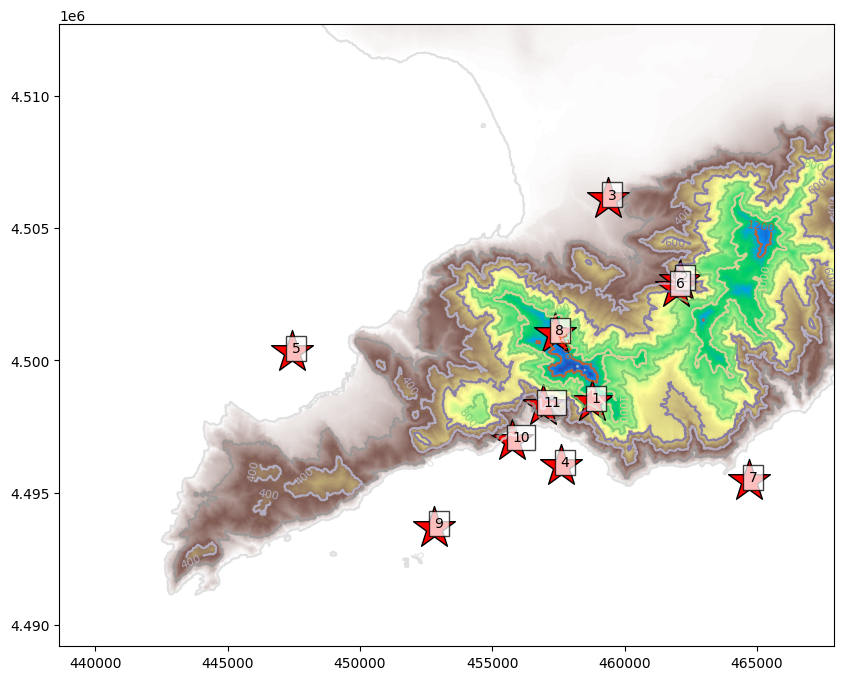

In [6]:
raster_data = rio.open(dem)

fig, ax = plt.subplots(figsize=(10, 10))
show(
    source=raster_data,
    cmap='tab20c_r',
    contour=True,
    ax=ax,
    transform=raster_data.transform
)
show(
    source=raster_data,
    cmap='terrain_r',
    ax=ax,
    transform=raster_data.transform
)
for _index, row in points_data.iterrows():
    coordinates = row.geometry.xy
    ax.scatter(
        *coordinates,
        s=1000,
        marker="*",
        facecolor='red',
        edgecolor='black'
    )
    plt.text(
        x=coordinates[0][0],
        y=coordinates[1][0],
        s=row.fid,
        fontdict=dict(color='black', size=10),
        bbox=dict(facecolor='white', alpha=0.75)
    )
plt.show()

# 2. Analisi su un singolo punto

In [7]:
single_point = points_data[points_data['fid'] == 11]
single_point

,fid,geometry
10,11,POINT (456914.431 4498265.587)


Ho selezionato solo il punto con id 11, è quello che ho usato nell'articolo del mio blog. Prima di partire con l'analisi è bene sapere che il risultato di una analisi di visibilità, detta anche *viewshed*, è un raster con valori che vanno da 0 a 180. Questi sono gradi e fanno riferimento alla visuale verticale dal punto di osservazione. Un valore pari a 0° sta ad indicare che quel pixel è proprio sotto il punto di osservazione, un valore pari a 90° sta a significare che il pixel è sull'orizzonte del punto di osservazione ed un valore pari a 180°, di conseguenza, indica che il pixel è proprio sopra il punto di osservazione.

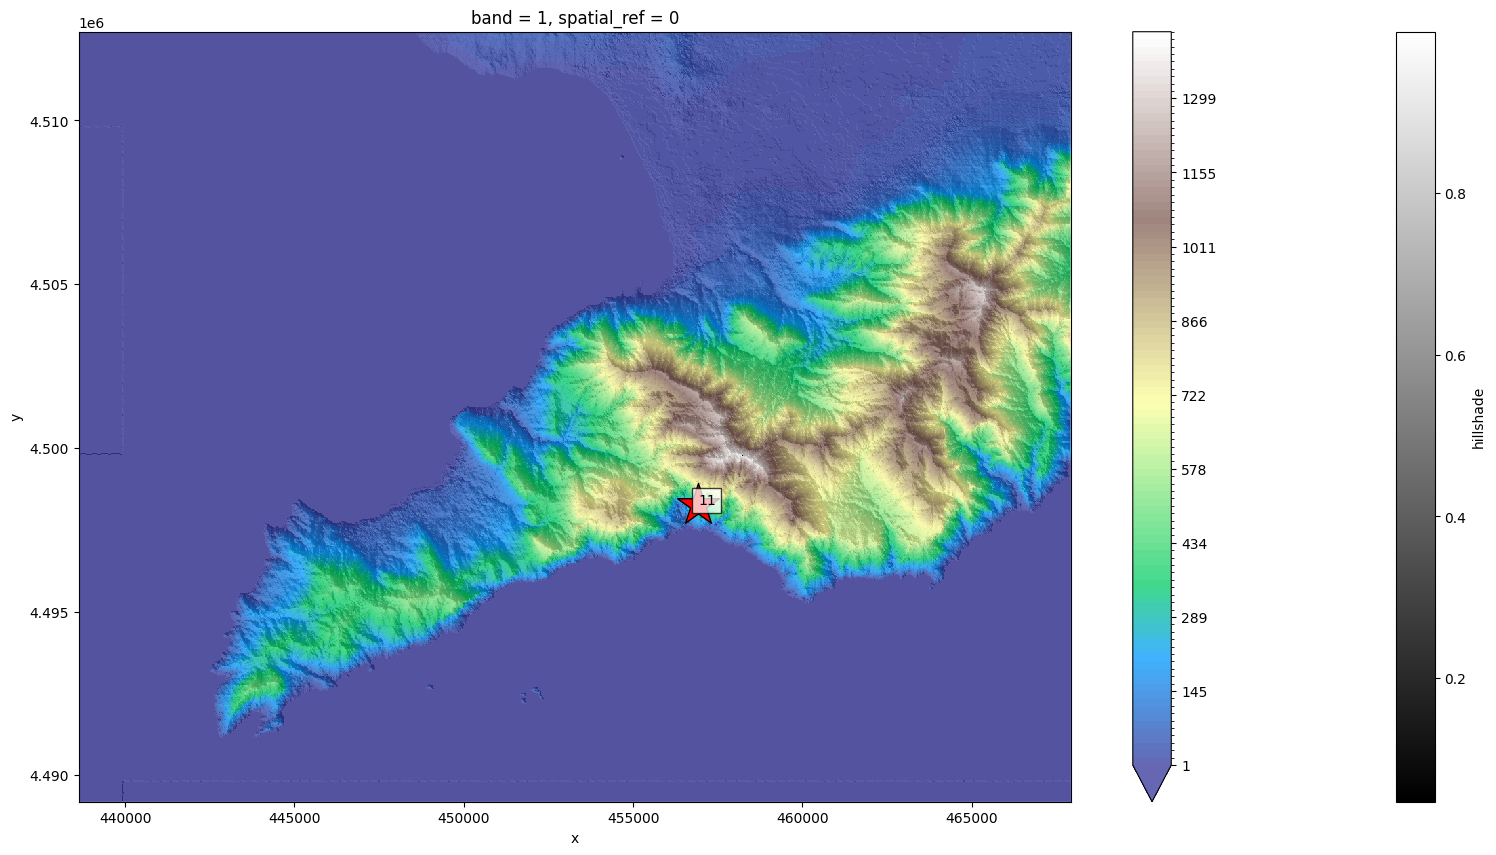

In [8]:
make_hillshade = hillshade(raster)

fig, ax = plt.subplots(figsize=(20, 10))
imshow(
    make_hillshade,
    ax=ax,
    cmap='gist_gray',
)
imshow(
    raster,
    ax=ax,
    cmap='terrain',
    vmin=1,
    vmax=max_h,
    levels=100,
    alpha=0.75
)
for _index, row in single_point.iterrows():
    coordinates = row.geometry.xy
    ax.scatter(
        *coordinates,
        s=1000,
        marker="*",
        facecolor='red',
        edgecolor='black'
    )
    plt.text(
        x=coordinates[0][0],
        y=coordinates[1][0],
        s=row.fid,
        fontdict=dict(color='black', size=10),
        bbox=dict(facecolor='white', alpha=0.75)
    )

plt.show()

Per una migliore resa visiva ho inserito la hillshade sotto al DEM tematizzato. Questa volta anzicchè usare la funzione `show` di *rasterio* ho preferito usare `imshow` di *xarray* per sperimentarla un po' visto che non l'avevo mai usata. E' interessante il fatto che aggiunga automaticamente la `colorbar` per ogni raster, devo capire come fare in modo che non venga visualizzata sempre e come disporla in altro modo.

## 2.1 Quota dell'osservatore

La quota dell'osservatore è un dato fondamentale per portare a termine una analisi di visibilità. Può essere la quota del punto in cui si trova l'osservatore o una quota fittizia compatibile con la topografia dell'area(l'osservatore fittizio non può essere a 100 metri di altezza se stiamo esaminando un'area in cui la quota minima è 500 metri). Quello che manca nei miei dati è proprio la quota!

Ma non è un problema perchè mi viene in soccorso [un'esperianza](https://maxdragonheart.github.io/PyGIS-Blog/point/2022/03/31/da-point-a-pointz.html) già fatta di recente e che vado a riprodurre:

In [9]:
x_coord = single_point.iloc[0].geometry.xy[0][0]
y_coord = single_point.iloc[0].geometry.xy[1][0]

dataarray_value = raster.sel(x=x_coord, y=y_coord, method="nearest")
pixel_value = dataarray_value.data

pixel_value

array(450, dtype=int16)

Ora che ho tutto quello che mi serve posso effettuare l'analisi di visibilità.

In [10]:
view = viewshed(raster, x=x_coord, y=y_coord, observer_elev=pixel_value)
view

<xarray.DataArray (y: 1176, x: 1464)>
array([[87.78651279, 87.78502168, 87.78352919, ..., -1.        ,
        -1.        , -1.        ],
       [87.78533465, 87.78384115, 87.78234627, ..., -1.        ,
        -1.        , -1.        ],
       [87.78415626, 87.78266038, 87.7811631 , ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [87.47039509, 87.46816885, 87.46593917, ..., -1.        ,
        -1.        , -1.        ],
       [87.47149388, 87.46927054, 87.46704378, ..., -1.        ,
        -1.        , -1.        ],
       [87.47259367, 87.47037324, 87.46814939, ..., -1.        ,
        -1.        , -1.        ]])
Coordinates:
    band         int64 1
  * x            (x) float64 4.386e+05 4.387e+05 ... 4.679e+05 4.679e+05
  * y            (y) float64 4.513e+06 4.513e+06 ... 4.489e+06 4.489e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

In [11]:
view_sel = view.where(view >= 0)
view_sel

<xarray.DataArray (y: 1176, x: 1464)>
array([[87.78651279, 87.78502168, 87.78352919, ...,         nan,
                nan,         nan],
       [87.78533465, 87.78384115, 87.78234627, ...,         nan,
                nan,         nan],
       [87.78415626, 87.78266038, 87.7811631 , ...,         nan,
                nan,         nan],
       ...,
       [87.47039509, 87.46816885, 87.46593917, ...,         nan,
                nan,         nan],
       [87.47149388, 87.46927054, 87.46704378, ...,         nan,
                nan,         nan],
       [87.47259367, 87.47037324, 87.46814939, ...,         nan,
                nan,         nan]])
Coordinates:
    band         int64 1
  * x            (x) float64 4.386e+05 4.387e+05 ... 4.679e+05 4.679e+05
  * y            (y) float64 4.513e+06 4.513e+06 ... 4.489e+06 4.489e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

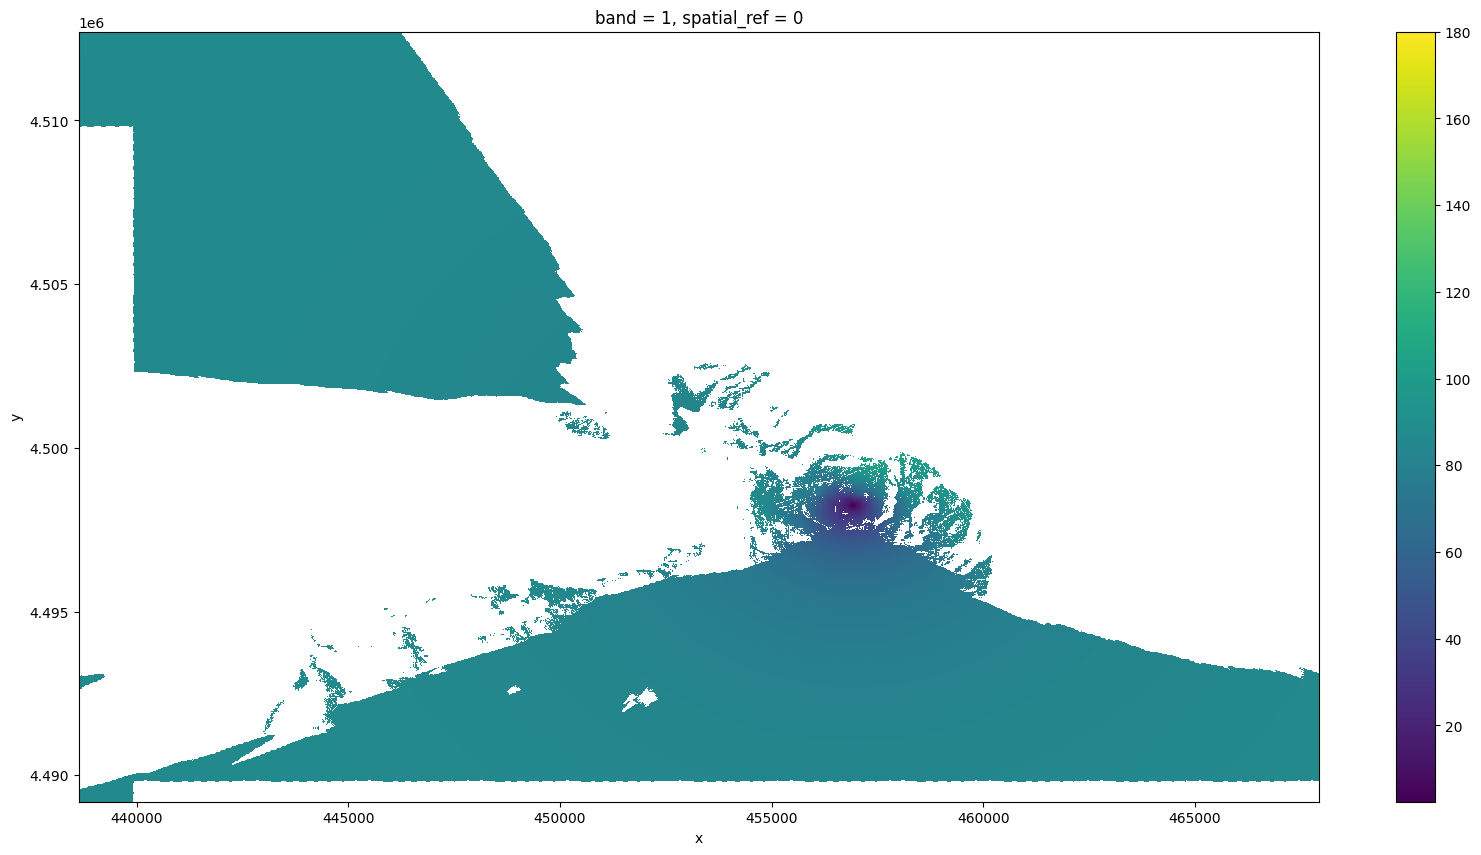

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
imshow(view_sel, ax=ax)
plt.show()

Analisi effettuata, ora sono curioso di vedere quali aree ricadono nel campo visivo dell'osservatore.

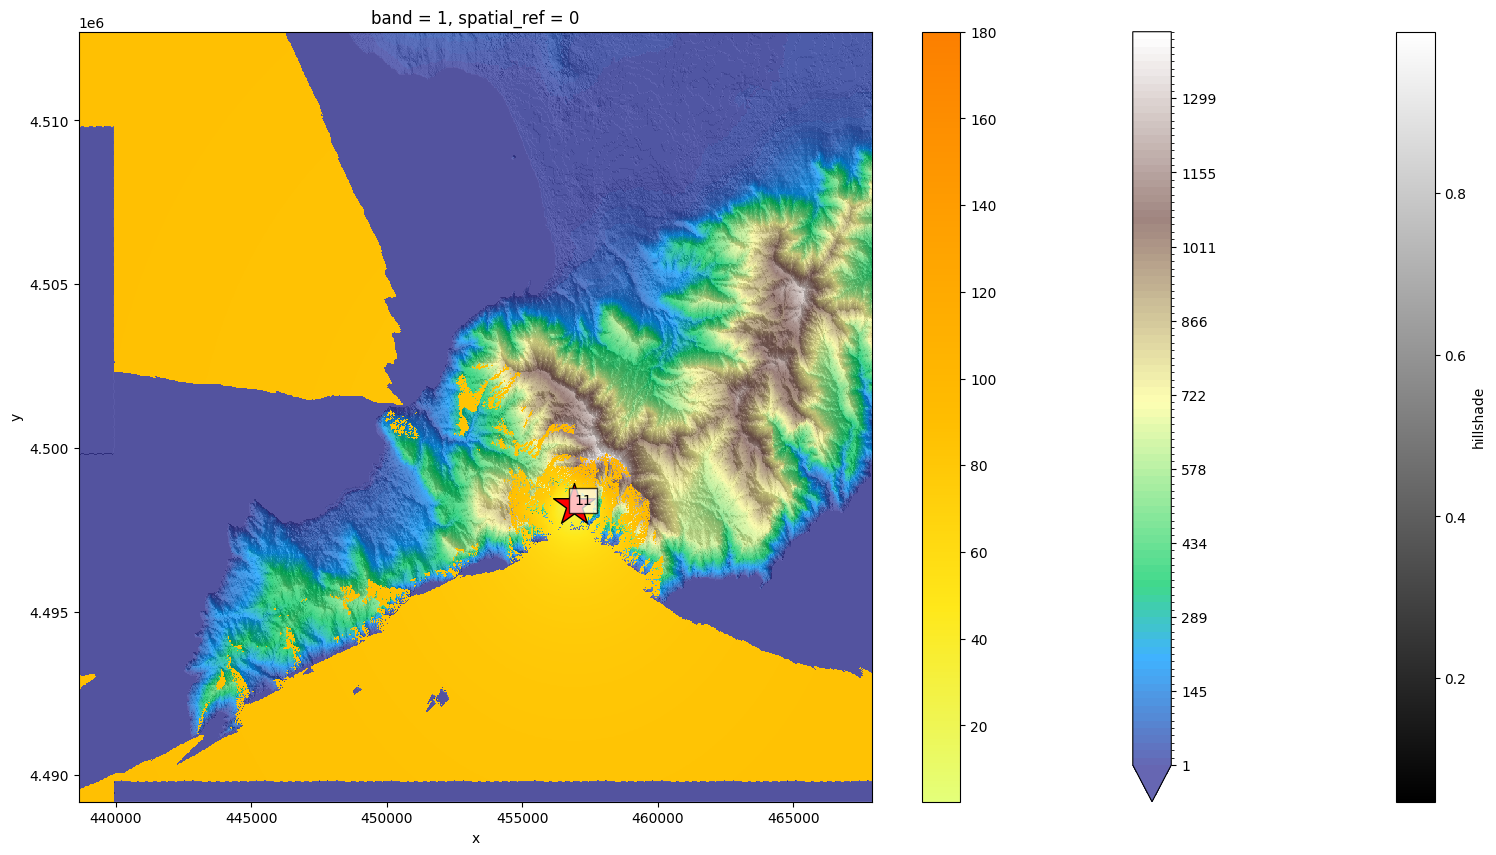

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
imshow(
    make_hillshade,
    ax=ax,
    cmap='gist_gray',
)
imshow(
    raster,
    ax=ax,
    cmap='terrain',
    vmin=1,
    vmax=max_h,
    levels=100,
    alpha=0.75
)
imshow(view_sel, ax=ax, cmap='Wistia')


ax.scatter(
    *single_point.iloc[0].geometry.xy,
    s=1000,
    marker="*",
    facecolor='red',
    edgecolor='black'
)
plt.text(
    x=coordinates[0][0],
    y=coordinates[1][0],
    s=row.fid,
    fontdict=dict(color='black', size=10),
    bbox=dict(facecolor='white', alpha=0.75)
)

plt.show()

Le aree in tonalità di giallo sono quelle che vede l'osservatore, in questo caso vede benissimo Positano, gli isolotti del Gallo e di Vetara ma anche parte del Golfo di Napoli, forse anche il Vesuvio.

# 3. Analisi multipla

E' arrivato il momento di usare tutti i punti!

In [14]:
for _index, row in points_data.iterrows():
    point_geometry = row.geometry.xy
    x_coord = point_geometry[0][0]
    y_coord = point_geometry[1][0]

    dataarray_value = raster.sel(x=x_coord, y=y_coord, method="nearest")
    pixel_value = dataarray_value.data

    view = viewshed(raster, x=x_coord, y=y_coord, observer_elev=pixel_value)

    view_sel = view.where(view >= 0)
    # Salvataggio dei risultati
    output_file = output_folder.joinpath(f'viewshed_point{row.fid}_h{pixel_value}.tif')
    view_sel.rio.to_raster(output_file)

![Point 1 - quota 875 metri](point_1.jpg "Point 1 - quota 875 metri")

![Point 2 - quota 413 metri](point_2.jpg "Point 2 - quota 413 metri")

![Point 3 - quota 106 metri](point_3.jpg "Point 3 - quota 106 metri")

![Point 4 - quota 0 metri](point_4.jpg "Point 4 - quota 0 metri")

![Point 5 - quota 0 metri](point_5.jpg "Point 5 - quota 0 metri")

![Point 6 - quota 475 metri](point_6.jpg "Point 6 - quota 475 metri")

![Point 7 - quota 0 metri](point_7.jpg "Point 7 - quota 0 metri")

![Point 8 - quota 1225 metri](point_8.jpg "Point 8 - quota 1225 metri")

![Point 9 - quota 0 metri](point_9.jpg "Point 9 - quota 0 metri")

![Point 10 - quota 0 metri](point_10.jpg "Point 10 - quota 0 metri")

![Point 11 - quota 450 metri](point_11.jpg "Point 11 - quota 450 metri")

# Conclusione

L'analisi di visibilità è fortemente infuenzata dalla risoluzione del DEM, più è spinta maggiore sarà la qualità dell'output. Di contro più è spinta la risoluzione del DEM maggiore sarà il tempo necessario per il processamento di ogni singolo punto di osservazione. Nel mio caso ci ho impiegato in media 4 secondi a punto.